# Fingerprint duplication analysis
## Hypothesis
- different molecules (=different inchikey14) should ideally have different fingerprints --> so we search for duplicate fingerprints
- particularly "bad": identical fingerprints for very different molecules. Since we cannot easily measure this without applying a reference score, we here simply use mass difference as an indicator (large mass difference should mean that they cannot be too similar, the opposite is not true though)

Data:

Compare multiple fingerprints on the "biomolecular structures" dataset (Fleming 2024, 718,067 compounds)
- Biomolecules dataset from Fleming et al. --> https://github.com/boecker-lab/myopic-mces-data

In [8]:
import os
import sys
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem


ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [4]:
import rdkit
print(rdkit.__version__)

assert int(rdkit.__version__[:4]) >= 2024

2024.03.6


In [5]:
filename = "biostructures_combined.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))

compounds.head()

,smiles
0,C1CCCC(CC1)CCCCCNCCSS(=O)(=O)O
1,CC1=CC2=C(C3=C(CCC3)C(=O)O2)C(=C1)OC4C(C(C(C(O...
2,C1=CC(=CC(=C1)Br)C(=O)NCC(=O)NN=CC2=C(C=C(C=C2...
3,COC(=O)CC(C1=CC=CC=C1)C2=C(C=C(C3=C2OC(=CC3=O)...
4,CC1C(OC(CC1=C)(C(C(=O)NC2C3C(C(C(C(O3)CC(CO)OC...


In [6]:
compounds.shape

(730464, 1)

## Helper functions

In [28]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_mass(smiles):
    # Convert SMILES string to a molecule object
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return "Invalid SMILES"
    # Calculate the molecular mass
    mass = Descriptors.MolWt(molecule)
    return mass

In [9]:
# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

# Import funtion/classes from source code
from fingerprint_computation import FingerprintGenerator, compute_fingerprints_from_smiles

In [25]:
from map4 import MAP4
from map4neo import MAP4neo

def compute_map_fingerprints_from_smiles(smiles, map_generator):
    
    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many(
        molecules,
        number_of_threads=32,
        verbose=True,
    )
    return list(fingerprints_map)

In [10]:
import hashlib

def row_to_hash(row):
    """Convert a numpy array row to a hash string using SHA256."""
    row_bytes = row.tobytes()
    return hashlib.sha256(row_bytes).hexdigest()

def find_duplicates_with_hashing(arr):
    hash_dict = {}
    duplicates = []

    # Convert each row to a hash and store the row indices that have the same hash
    for idx, row in enumerate(arr):
        row_hash = row_to_hash(row)
        if row_hash in hash_dict:
            hash_dict[row_hash].append(idx)
        else:
            hash_dict[row_hash] = [idx]

    # Collect all rows that have duplicate hashes
    for indices in hash_dict.values():
        if len(indices) > 1:
            duplicates.append(indices)

    return duplicates

## Compute all compound masses

In [ ]:
masses = []
for smiles_string in tqdm(compounds.smiles):
    masses.append(calculate_mass(smiles_string))

masses = np.array(masses)

  0%|          | 0/730464 [00:00<?, ?it/s]

## Run experiments

Compute fingerprints and detect duplicates.
This takes some time to compute.

In [23]:
experiments = [
    ("morgan2_count", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), True),
    ("morgan3_count", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    #("morgan4_count", rdFingerprintGenerator.GetMorganGenerator(radius=4, fpSize=4096), True),
    #("morgan5_count", rdFingerprintGenerator.GetMorganGenerator(radius=5, fpSize=4096), True),
    ("morgan6_count", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096), True),
    ("morgan9_count", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan2_binary", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), False),
    ("morgan3_binary", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("morgan2_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024), False),
    ("morgan3_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=1024), False),
    #("morgan6_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=1024), False),
    ("rdkit", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("rdkit_1024", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=1024), False),
    ("map2", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
]

In [ ]:
# Path to store collected duplicates and bit occupations
path_results = os.path.join(Path(ROOT), "experiments")

for experiment in experiments:
    (name, fpgen, count) = experiment
    if os.path.exists(os.path.join(path_results, f"{name}_duplicates.pickle")):
        print(f"----- Found existing results for experiment: {name} -----")
        print(f"----- (experiment will be skipped) -----")
        continue

    print(f"----- Experiment: {name} -----")

    if "map" in name:
        fingerprints = compute_map_fingerprints_from_smiles(compounds.smiles, fpgen)
    else:
        fingerprints = compute_fingerprints_from_smiles(
            compounds.smiles, fpgen, sparse=False,
            count=count, progress_bar=True
        )
        fingerprints = np.stack(fingerprints)

    print(f"Collected {fingerprints.shape[0]} fingerprints.")

    bins_occupied = (fingerprints > 0).sum(axis=0).astype(np.float64)
    bins_occupied *= (100 / len(fingerprints))
    np.save(os.path.join(path_results, f"{name}_bins_occupied.npy"), bins_occupied)

    print(f"# of bins occupied in 1% or more of all fingerprints: {(bins_occupied >= 1).sum()}")
    print(f"# of bins occupied in 10% or more of all fingerprints: {(bins_occupied >= 10).sum()}")
    print(f"# of bins occupied in 50% or more of all fingerprints: {(bins_occupied >= 50).sum()}")

    # Search fingerprint duplicated
    duplicates = find_duplicates_with_hashing(fingerprints)
    duplicate_statistics = np.array([len(x) for x in duplicates])
    with open(os.path.join(path_results, f"{name}_duplicates.pickle"), "wb") as handle:
        pickle.dump(duplicates, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Total of {sum(duplicate_statistics)} compounds have duplicated fingerprints.")
    print(f"The largest cluster has {max(duplicate_statistics)} compounds with identical fingerprint.")

----- Experiment: morgan2_count -----


100%|█████████████████████████████████| 730464/730464 [02:27<00:00, 4948.00it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 753
# of bins occupied in 10% or more of all fingerprints: 71
# of bins occupied in 50% or more of all fingerprints: 10
Total of 74593 compounds have duplicated fingerprints.
The largest cluster has 381 compounds with identical fingerprint.
----- Experiment: morgan3_count -----


100%|█████████████████████████████████| 730464/730464 [02:57<00:00, 4125.96it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 1415
# of bins occupied in 10% or more of all fingerprints: 82
# of bins occupied in 50% or more of all fingerprints: 10
Total of 65189 compounds have duplicated fingerprints.
The largest cluster has 381 compounds with identical fingerprint.
----- Experiment: morgan6_count -----


100%|█████████████████████████████████| 730464/730464 [04:35<00:00, 2653.66it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 4028
# of bins occupied in 10% or more of all fingerprints: 107
# of bins occupied in 50% or more of all fingerprints: 10
Total of 43930 compounds have duplicated fingerprints.
The largest cluster has 81 compounds with identical fingerprint.
----- Experiment: morgan9_count -----


100%|█████████████████████████████████| 730464/730464 [05:33<00:00, 2189.69it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 4096
# of bins occupied in 10% or more of all fingerprints: 115
# of bins occupied in 50% or more of all fingerprints: 10
Total of 21264 compounds have duplicated fingerprints.
The largest cluster has 7 compounds with identical fingerprint.
----- Experiment: morgan2_binary -----


100%|█████████████████████████████████| 730464/730464 [02:10<00:00, 5579.09it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 753
# of bins occupied in 10% or more of all fingerprints: 71
# of bins occupied in 50% or more of all fingerprints: 10
Total of 101091 compounds have duplicated fingerprints.
The largest cluster has 11332 compounds with identical fingerprint.
----- Experiment: morgan3_binary -----


100%|█████████████████████████████████| 730464/730464 [02:52<00:00, 4240.81it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 1415
# of bins occupied in 10% or more of all fingerprints: 82
# of bins occupied in 50% or more of all fingerprints: 10
Total of 87147 compounds have duplicated fingerprints.
The largest cluster has 11332 compounds with identical fingerprint.
----- Experiment: morgan2_binary_1024 -----


100%|█████████████████████████████████| 730464/730464 [02:25<00:00, 5030.01it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 985
# of bins occupied in 10% or more of all fingerprints: 89
# of bins occupied in 50% or more of all fingerprints: 9
Total of 101447 compounds have duplicated fingerprints.
The largest cluster has 11332 compounds with identical fingerprint.
----- Experiment: morgan3_binary_1024 -----


100%|█████████████████████████████████| 730464/730464 [02:56<00:00, 4128.12it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 1024
# of bins occupied in 10% or more of all fingerprints: 124
# of bins occupied in 50% or more of all fingerprints: 9
Total of 87281 compounds have duplicated fingerprints.
The largest cluster has 11332 compounds with identical fingerprint.
----- Experiment: morgan6_binary_1024 -----


100%|█████████████████████████████████| 730464/730464 [04:06<00:00, 2962.20it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 1024
# of bins occupied in 10% or more of all fingerprints: 257
# of bins occupied in 50% or more of all fingerprints: 10
Total of 63136 compounds have duplicated fingerprints.
The largest cluster has 1975 compounds with identical fingerprint.
----- Experiment: rdkit -----


100%|██████████████████████████████████| 730464/730464 [23:29<00:00, 518.22it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 4096
# of bins occupied in 10% or more of all fingerprints: 3782
# of bins occupied in 50% or more of all fingerprints: 83
Total of 131965 compounds have duplicated fingerprints.
The largest cluster has 14153 compounds with identical fingerprint.
----- Experiment: rdkit_1024 -----


100%|██████████████████████████████████| 730464/730464 [22:34<00:00, 539.12it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 1024
# of bins occupied in 10% or more of all fingerprints: 1024
# of bins occupied in 50% or more of all fingerprints: 609
Total of 147388 compounds have duplicated fingerprints.
The largest cluster has 14153 compounds with identical fingerprint.


ValueError: not enough values to unpack (expected 3, got 2)

In [41]:
# Path to store collected duplicates and bit occupations
path_results = os.path.join(Path(ROOT), "experiments")

for experiment in experiments:
    (name, fpgen, count) = experiment
    if os.path.exists(os.path.join(path_results, f"{name}_duplicates.pickle")):
        print(f"----- Found existing results for experiment: {name} -----")
        print(f"----- (experiment will be skipped) -----")
        continue

    print(f"----- Experiment: {name} -----")

    if "map" in name:
        fingerprints = compute_map_fingerprints_from_smiles(compounds.smiles, fpgen)
    else:
        fingerprints = compute_fingerprints_from_smiles(
            compounds.smiles, fpgen, sparse=False,
            count=count, progress_bar=True
        )
        fingerprints = np.stack(fingerprints)

    print(f"Collected {fingerprints.shape[0]} fingerprints.")

    bins_occupied = (fingerprints > 0).sum(axis=0).astype(np.float64)
    bins_occupied *= (100 / len(fingerprints))
    np.save(os.path.join(path_results, f"{name}_bins_occupied.npy"), bins_occupied)

    print(f"# of bins occupied in 1% or more of all fingerprints: {(bins_occupied >= 1).sum()}")
    print(f"# of bins occupied in 10% or more of all fingerprints: {(bins_occupied >= 10).sum()}")
    print(f"# of bins occupied in 50% or more of all fingerprints: {(bins_occupied >= 50).sum()}")

    # Search fingerprint duplicated
    duplicates = find_duplicates_with_hashing(fingerprints)
    duplicate_statistics = np.array([len(x) for x in duplicates])
    with open(os.path.join(path_results, f"{name}_duplicates.pickle"), "wb") as handle:
        pickle.dump(duplicates, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Total of {sum(duplicate_statistics)} compounds have duplicated fingerprints.")
    print(f"The largest cluster has {max(duplicate_statistics)} compounds with identical fingerprint.")

----- Found existing results for experiment: morgan2_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan3_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan6_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan9_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan2_binary -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan3_binary -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan2_binary_1024 -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan3_binary_1024 -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: rdkit -----
----- (experiment will be skipped) -----
----- Found existing results for experim

[18:17:38] WARNING: not removing hydrogen atom without neighbors
[18:18:05] WARNING: not removing hydrogen atom without neighbors
[18:18:20] WARNING: not removing hydrogen atom without neighbors


Calculating fingerprints:   0%|                      | 0/730464 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'shape'

In [42]:
fingerprints.shape

AttributeError: 'list' object has no attribute 'shape'

In [43]:
fingerprints = np.stack(fingerprints)
fingerprints.shape

(730464, 4096)

In [44]:
print(f"Collected {fingerprints.shape[0]} fingerprints.")

bins_occupied = (fingerprints > 0).sum(axis=0).astype(np.float64)
bins_occupied *= (100 / len(fingerprints))
np.save(os.path.join(path_results, f"{name}_bins_occupied.npy"), bins_occupied)

print(f"# of bins occupied in 1% or more of all fingerprints: {(bins_occupied >= 1).sum()}")
print(f"# of bins occupied in 10% or more of all fingerprints: {(bins_occupied >= 10).sum()}")
print(f"# of bins occupied in 50% or more of all fingerprints: {(bins_occupied >= 50).sum()}")

# Search fingerprint duplicated
duplicates = find_duplicates_with_hashing(fingerprints)
duplicate_statistics = np.array([len(x) for x in duplicates])
with open(os.path.join(path_results, f"{name}_duplicates.pickle"), "wb") as handle:
    pickle.dump(duplicates, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Total of {sum(duplicate_statistics)} compounds have duplicated fingerprints.")
print(f"The largest cluster has {max(duplicate_statistics)} compounds with identical fingerprint.")

Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 4096
# of bins occupied in 10% or more of all fingerprints: 3965
# of bins occupied in 50% or more of all fingerprints: 5
Total of 238 compounds have duplicated fingerprints.
The largest cluster has 176 compounds with identical fingerprint.


## Compare experiments

In [45]:
def compute_group_mass_diff(group_indices, masses):
    """
    Given a list/array of indices corresponding to compounds in a duplicate group,
    compute the mass range (max - min) for that group.
    """
    group_masses = masses[group_indices]
    return group_masses.max() - group_masses.min()


results_folder = os.path.join(Path(ROOT), "experiments")
experiment_names = [x[0] for x in experiments]


results = []
for exp_name in tqdm(experiment_names):
    dup_file = os.path.join(results_folder, f"{exp_name}_duplicates.pickle")
    bins_file = os.path.join(results_folder, f"{exp_name}_bins_occupied.npy")
    
    # If either file is missing, skip this experiment.
    if not os.path.exists(dup_file) or not os.path.exists(bins_file):
        print(f"Results for experiment {exp_name} not found, skipping.")
        continue

    # Load duplicate groups.
    with open(dup_file, "rb") as f:
        duplicates = pickle.load(f)

    # Total duplicates: count all compounds that appear in any duplicate group.
    total_duplicates = sum(len(group) for group in duplicates)
    
    # Count the duplicates in groups where the max-mass difference is at least 200.
    duplicates_mass_diff = 0
    for group in duplicates:
        # Convert group to a NumPy array (if not already) to index into masses.
        group_indices = np.array(group)
        if len(group_indices) == 0:
            continue  # Skip if group is empty for any reason.
        mass_diff = compute_group_mass_diff(group_indices, masses)
        if mass_diff >= 200:
            duplicates_mass_diff += len(group_indices)
    
    # Load the bins occupancy data.
    bins_occupied = np.load(bins_file)
    mean_bins = bins_occupied.mean() / 100 * len(bins_occupied)
    std_bins = bins_occupied.std() / 100 * len(bins_occupied)

    # Append the experiment summary to our results list.
    results.append({
        "experiment": exp_name,
        "total_duplicates": total_duplicates,
        "duplicates_mass_diff_ge_200": duplicates_mass_diff,
        "mean_bins_occupied": mean_bins,
        "std_bins_occupied": std_bins,
    })

# Create a Pandas DataFrame for a neat summary.
df_results = pd.DataFrame(results)
df_results

  0%|          | 0/12 [00:00<?, ?it/s]

,experiment,total_duplicates,duplicates_mass_diff_ge_200,mean_bins_occupied,std_bins_occupied
0,morgan2_count,74593,0,47.868237,171.607494
1,morgan3_count,65189,0,66.430276,172.754879
2,morgan6_count,43930,0,100.464164,175.298645
3,morgan9_count,21264,0,118.075002,176.387236
4,morgan2_binary,101091,64523,47.868237,171.607494
5,morgan3_binary,87147,53821,66.430276,172.754879
6,morgan2_binary_1024,101447,64574,46.607222,82.289475
7,morgan3_binary_1024,87281,53859,64.317120,81.952001
8,rdkit,131965,72749,845.867714,429.547126
9,rdkit_1024,147388,74789,548.311683,109.886141


In [52]:
files_experiments = [
    ("rdkit", "RDKit fingerprint (4096 bits)"),
    ("rdkit_1024", "RDKit fingerprint (1024 bits)"),
    ("morgan2_binary", "Morgan-2 fingerprint (4096 bits)"),
    ("morgan2_count", "Morgan-2 count fingerprint (4096 bits)"),
    ("morgan2_binary_1024", "Morgan-2 fingerprint (1024 bits)"),
    ("morgan3_binary", "Morgan-3 fingerprint (4096 bits)"),
    ("morgan3_count", "Morgan-3 count fingerprint (4096 bits)"),
    ("morgan3_binary_1024", "Morgan-3 fingerprint (1024 bits)"),
    ("morgan6_count", "Morgan-6 count fingerprint (4096 bits)"),
    ("morgan6_binary_1024", "Morgan-6 fingerprint (1024 bits)"),
    ("map4", "MAP4 fingerprint (r=2, 4096 bits)")
]


colors = ["#00A878", "#00A878",
          "#F3C178", "#F3C178", 
          "#C24831", "#C24831", 
          "#8532B1", "#8532B1",
          "#3333D1"]#, "#3333D1"]

/tmp/ipykernel_277141/1303697392.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 100])


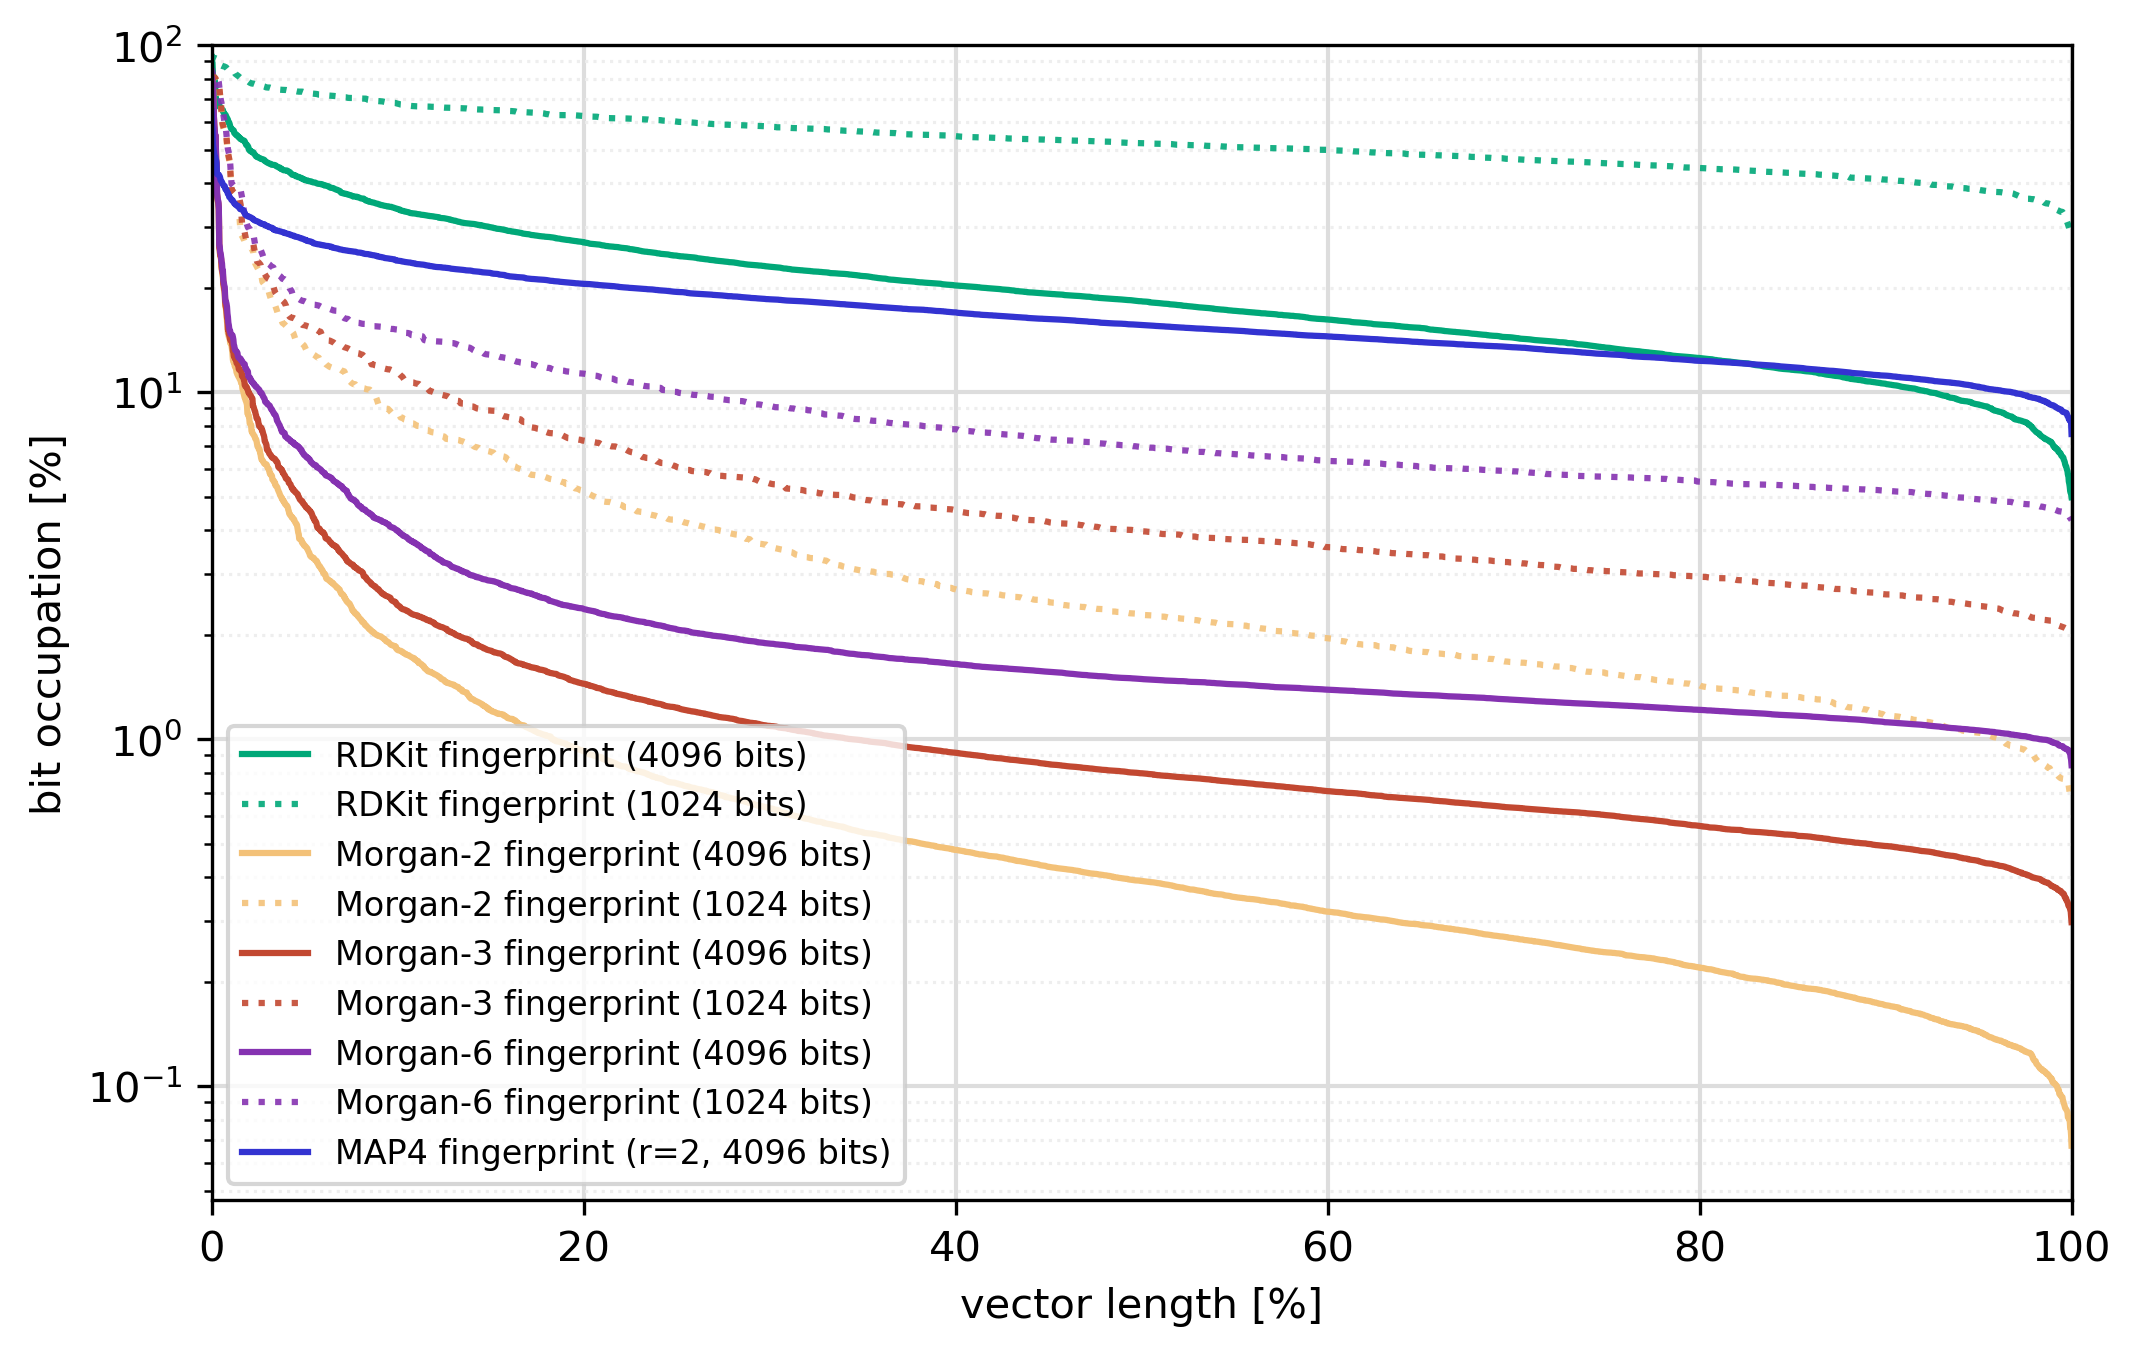

In [54]:
plt.style.use('default')


fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

fig_i = -1
for i, (file, name) in enumerate(files_experiments):
    if "count" in name:
        if file[:7]+"_binary" in [x[0] for x in files_experiments]:
            continue
    fig_i += 1
    bins_occupied = np.load(os.path.join(path_results, f"{file}_bins_occupied.npy"))
    order = np.argsort(bins_occupied)[::-1]
    bins_scaled = np.linspace(0, 100, len(bins_occupied))


    if "1024" in name:
        ax.plot(bins_scaled, bins_occupied[order], ":", linewidth=1.5, color=colors[fig_i], alpha=0.9, label=name.replace(" count", ""))
    else:
        ax.plot(bins_scaled, bins_occupied[order], linewidth=1.5, color=colors[fig_i], label=name.replace(" count", ""))

ax.set_yscale("log")
ax.set_ylabel("bit occupation [%]")
ax.set_xlabel("vector length [%]")
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

# Grid
ax.grid(which='major', color='#DDDDDD', linewidth=1)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)


plt.legend(fontsize=8)
plt.savefig("Bit_occupation_distributions_scaled_700k.pdf")
plt.savefig("Bit_occupation_distributions_scaled_700k.png", dpi=300)
plt.show()


In [59]:
plt.style.use('ggplot')
#plt.style.use("fivethirtyeight")

In [68]:
files_experiments = [
    ("rdkit", "RDKit fingerprint (4096 bits)"),
    ("rdkit_1024", "RDKit fingerprint (1024 bits)"),
    ("morgan2_binary", "Morgan-2 fingerprint (4096 bits)"),
    ("morgan2_count", "Morgan-2 count fingerprint (4096 bits)"),
    ("morgan2_binary_1024", "Morgan-2 fingerprint (1024 bits)"),
    ("morgan3_binary", "Morgan-3 fingerprint (4096 bits)"),
    ("morgan3_count", "Morgan-3 count fingerprint (4096 bits)"),
    ("morgan3_binary_1024", "Morgan-3 fingerprint (1024 bits)"),
    ("morgan4_count", "Morgan-4 count fingerprint (4096 bits)"),
    ("morgan5_count", "Morgan-5 count fingerprint (4096 bits)"),
    ("morgan6_count", "Morgan-6 count fingerprint (4096 bits)"),
    ("morgan6_binary_1024", "Morgan-6 fingerprint (1024 bits)"),
    ("map4_4096", "MAP4 fingerprint (r=2, 4096 bits)")
]

## TAKE CARE: this will take the max difference per duplicates group
This is rather pessimistic, but might give an idea of the "risk" to find *very* different compounds for the same fingerprints.

After all 5 identical fingerprints with masses [200, 210, 350, 380, 500] would not all correspond to a max mass difference of 300.

In [57]:
def compute_compound_max_differences(masses):
    all_max_diffs = []
    min_mass = masses.min()
    max_mass = masses.max()
    for mass in masses:
        max_diff = max(mass - min_mass, max_mass - mass)
        all_max_diffs.append(max_diff)

    return np.array(all_max_diffs)

In [98]:
colors = ["#00A878", "#6CCD8C",
          "#E6D98C", "#F1C178",
          "#F16666", "#DD2222",
          ]

In [63]:
files_experiments = [
    ("rdkit", "RDKit fingerprint (4096 bits)"),
    ("rdkit_1024", "RDKit fingerprint (1024 bits)"),
    ("morgan2_binary", "Morgan-2 fingerprint (4096 bits)"),
    ("morgan2_count", "Morgan-2 count fingerprint (4096 bits)"),
    ("morgan2_binary_1024", "Morgan-2 fingerprint (1024 bits)"),
    ("morgan3_binary", "Morgan-3 fingerprint (4096 bits)"),
    ("morgan3_count", "Morgan-3 count fingerprint (4096 bits)"),
    ("morgan3_binary_1024", "Morgan-3 fingerprint (1024 bits)"),
    ("morgan6_count", "Morgan-6 count fingerprint (4096 bits)"),
    ("morgan6_binary_1024", "Morgan-6 fingerprint (1024 bits)"),
    ("morgan9_count", "Morgan-9 count fingerprint (4096 bits)"),
    ("map2", "MAP4 fingerprint (r=1, 4096 bits)"),
    ("map4", "MAP4 fingerprint (r=2, 4096 bits)")
]

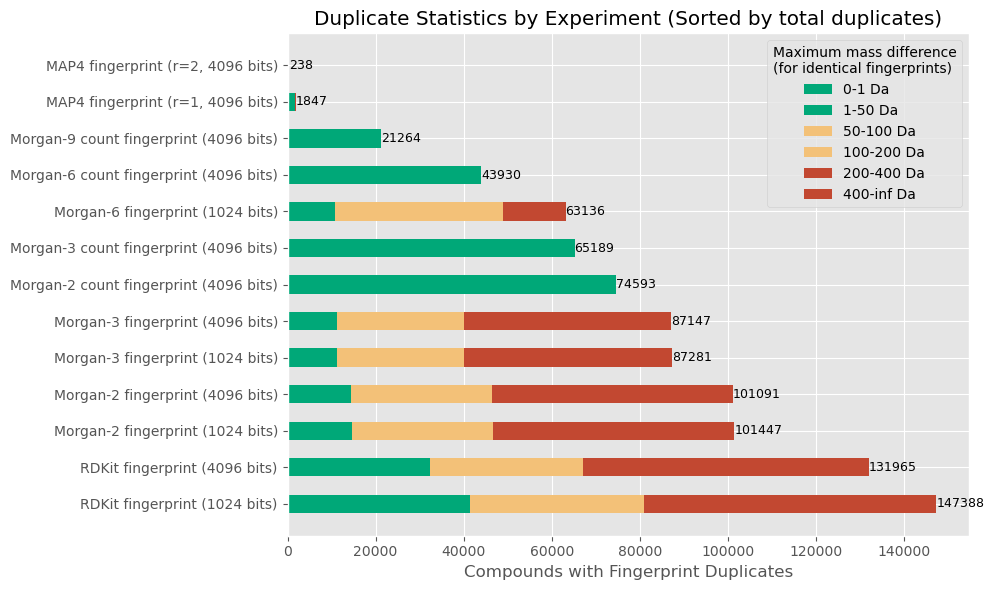

In [64]:
# Define the bins
bins = [(0, 1), (1, 50), (50, 100), (100, 200), (200, 400), (400, np.inf)]
bin_labels = [f"{low}-{high} Da" if high != np.inf else f"{low}-inf Da" for low, high in bins]


# Initialize results storage
experiment_sums = {name: np.zeros(len(bins)) for _, name in files_experiments}

# Process each experiment
for file, name in files_experiments:
    # Load duplicates data
    with open(os.path.join(path_results, f"{file}_duplicates.pickle"), "rb") as f:
        duplicates = pickle.load(f)

    # Calculate statistics
    duplicate_statistics = np.array([len(x) for x in duplicates])
    duplicate_masses = [masses[i] for i in duplicates]
    max_mass_differences = np.concatenate([compute_compound_max_differences(x) for x in duplicate_masses])

    # Compute sums for each bin
    for i, (low, high) in enumerate(bins):
        idx = np.where((max_mass_differences >= low) & (max_mass_differences < high))[0]
        experiment_sums[name][i] = idx.shape[0]

# Sort experiments by total sum
sorted_experiments = sorted(
    experiment_sums.items(), 
    key=lambda item: item[1].sum(), 
    reverse=True
)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare for stacked bar chart
width = 0.5
y_positions = np.arange(len(sorted_experiments))
left_stack = np.zeros(len(sorted_experiments))

# Iterate over bins and stack their sums
for i, label in enumerate(bin_labels):
    values = [experiment[1][i] for experiment in sorted_experiments]
    ax.barh(y_positions, values, width, label=label, left=left_stack, color=colors[i])
    left_stack += values

# Add numbers
for i, y in enumerate(y_positions):
    value = sorted_experiments[i][1].sum()
    plt.text(value, i-0.1, f"{value:.0f}", fontsize=9)

# Configure plot appearance
ax.set_yticks(y_positions)
ax.set_yticklabels([experiment[0] for experiment in sorted_experiments])
ax.set_xlabel("Compounds with Fingerprint Duplicates")
ax.set_title("Duplicate Statistics by Experiment (Sorted by total duplicates)")
ax.legend(title="Maximum mass difference\n(for identical fingerprints)", loc="upper right")

plt.tight_layout()
plt.savefig("Duplicate_statistics_max_mass_difference_700k.pdf")
plt.savefig("Duplicate_statistics_max_mass_difference_700k.png", dpi=600)
plt.show()
